# NVIDIA Rapids Demo with DBSCAN

### DBSCAN is a density-based clustering algorithm that can automatically classify groups of data, without the user having to specify how many groups there are.

#### Density-based spatial clustering of applications with noise (DBSCAN)

##### Basic Idea: take a point in a dataset, draw a circle of radius $\varepsilon$ around it. If $N$ or more other points are within the circle, a group if formed. Build out the group by repeating the algo for the neighbors.

In [3]:
%matplotlib inline
import sys
sys.path.append('../common')
from plt_style import *
from sklearn.datasets import make_circles
import numpy
import cupy
import pandas as pd, numpy as np
import cudf
import os
import pylab as plt

In [4]:
!nvidia-smi

Mon Sep 25 10:36:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   28C    P0    74W / 500W |    415MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

In [5]:
X, y = make_circles(n_samples=2**17, factor=.35, noise=.05)
X *= 3

In [6]:
print(X.shape)
y

(131072, 2)


array([1, 1, 0, ..., 0, 1, 1])

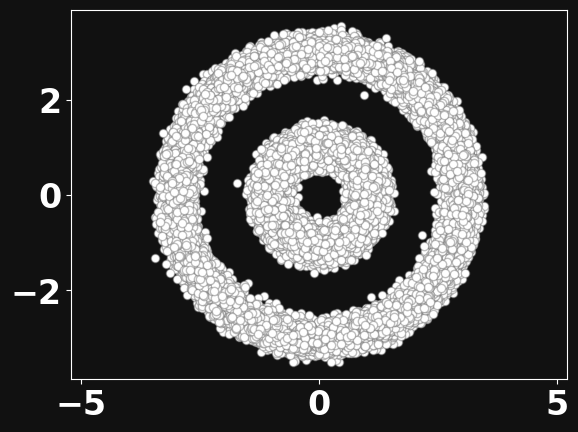

In [7]:
my_scatter(*X.T,c='w',edgecolor='#77777777')
_=plt.axis('equal')

In [8]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=2)

In [9]:
%%time
y_db = db.fit_predict(X)

CPU times: user 8.32 s, sys: 2.35 s, total: 10.7 s
Wall time: 10.7 s


In [10]:
!uptime

 10:36:56 up 42 days,  1:02, 11 users,  load average: 0.81, 0.32, 0.20


In [11]:
print(f'Number of classifier errors: {sum(y_db-y)}')

Number of classifier errors: 0


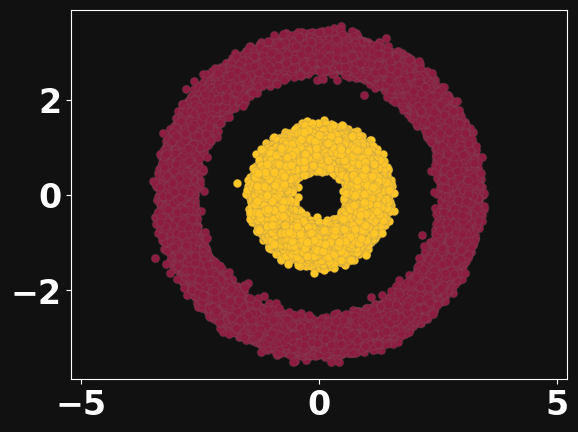

In [12]:
mask0,mask1 = y_db == 0, y_db==1
my_scatter(*X[mask0].T,c=gld,edgecolor='#77777722')
my_scatter(*X[mask1].T,c=mrn,edgecolor='#77777722')
_=plt.axis('equal')

Now on the GPU 
--------------

In [13]:
X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.from_pandas(X_df)

In [14]:
print(f'Proof on GPU: {X_gpu.values.device}')

Proof on GPU: <CUDA Device 0>


In [15]:
%%time
from cuml import DBSCAN as cumlDBSCAN
db_gpu = cumlDBSCAN(eps=0.6, min_samples=2)

CPU times: user 364 ms, sys: 105 ms, total: 469 ms
Wall time: 5 s


In [16]:
%%time
y_db_gpu = db_gpu.fit_predict(X_gpu)

[W] [10:37:16.229332] Batch size limited by the chosen integer type (4 bytes). 103801 -> 16383. Using the larger integer type might result in better performance
CPU times: user 1.21 s, sys: 226 ms, total: 1.44 s
Wall time: 8.67 s


In [17]:
!nvidia-smi

Mon Sep 25 10:37:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   31C    P0    85W / 500W |   1325MiB / 81920MiB |     97%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

In [18]:
print(f'Number of classifier errors: {sum(cupy.asnumpy(y_db_gpu.values)-y)}')

Number of classifier errors: 0


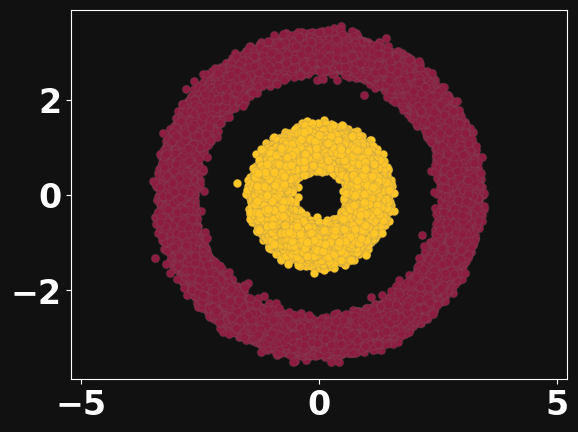

In [23]:
mask0,mask1 = y_db_gpu == 0, y_db_gpu==1
my_scatter(*X_gpu[mask0].to_numpy().T,c=gld,edgecolor='#77777722')
my_scatter(*X_gpu[mask1].to_numpy().T,c=mrn,edgecolor='#77777722')
_=plt.axis('equal')

![](./speedup.png)

https://towardsdatascience.com/heres-how-you-can-accelerate-your-data-science-on-gpu-4ecf99db3430